# KIỂM TRA GIỮA KỲ - Image Classification
##THÔNG TIN SINH VIÊN:
- Nguyễn Hùng Anh
- 21064051

#Bài toán phân loại phương tiện giao thông

Tổng quan: Thực hiên các bước để xây dựng một hệ thống học máy cho bài toán phân loại phương tiện giao thông: khảo sát dữ liệu, trích xuất đặc trưng, xây dựng mô hình phân loại, phân loại trên hình ảnh thực tế. Yêu cầu các kiến thức về lập trình Python với các thư viện: OpenCV, scikit-learn, pickle, numpy.

In [231]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import sklearn

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

## Câu hỏi 1: Khảo sát tập dữ liệu
Thư mục trainingset bao gồm 5 thư mục con ứng với 5 nhãn của bài toán, trong mỗi thư mục con chứa ảnh tương ứng với nhãn.
### Câu hỏi 1.1: Quan sát một vài mẫu dữ liệu
Viết hàm load_image() nhận đầu vào là đường dẫn ảnh, trả về mảng numpy lưu trữ ảnh, sử dụng thư viện OpenCV.

In [232]:
def load_image(image_path):
    #### YOUR CODE HERE ####
    return cv2.imread(image_path)
    #### END YOUR CODE #####

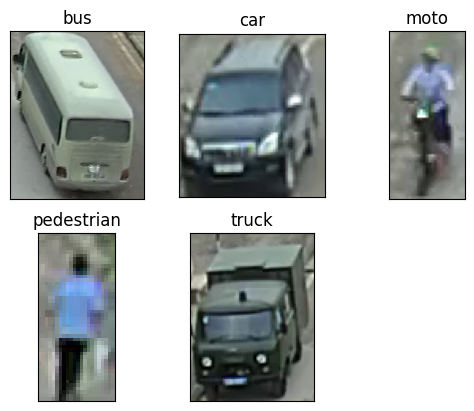

In [233]:
samples_list = []
samples_label = []

for label in os.listdir("../TK1/trainingset"):

    label_path = os.path.join("../TK1/trainingset", label)
    if not os.path.isdir(label_path):
        continue

    sample_file = os.listdir(os.path.join("../TK1/trainingset", label))[0]

    samples_list.append(load_image(os.path.join("../TK1/trainingset", label, sample_file)))

    samples_label.append(label)

for i in range(len(samples_list)):
    plt.subplot(2, 3, i + 1), plt.imshow(cv2.cvtColor(samples_list[i], cv2.COLOR_BGR2RGB))
    plt.title(samples_label[i]), plt.xticks([]), plt.yticks([])

plt.show()

Một vài hàm hay sử dụng trong thư viện os:
- Hàm os.listdir(path): Trả về một list chứa tên các thư mục và file nằm trong thư mục path. Vì hàm trả về một list nên ta có thể tính được tổng số folder và file trong một thư mục (dùng hàm len())
- Hàm os.path.join(t1, t2, [t3, ...]): Trả về đường dẫn trong hệ điều hành tương ứng nối các đường dẫn t1, t2, t3,... Ví dụ ta có t1 = 'trainingset', t2 = 'image' thì hàm trả về xâu s = 'trainingset/image' với Ubuntu hoặc s = 'trainingset\\image' với Windows.

### Câu hỏi 1.2: Thống kê dữ liệu
Hãy viết hàm statistic() để thống kê số lượng ảnh ứng với mỗi nhãn. Hàm statistic() cần trả về 2 danh sách (list): label, num_images. Danh sách label lưu tên các nhãn và danh sách num_images lưu số lượng ảnh tương ứng với nhãn lưu ở danh sách label.

In [234]:
def statistic():
    label = []
    num_images = []

    for category in os.listdir("../TK1/trainingset"):
        category_path = os.path.join("../TK1/trainingset", category)

        if not os.path.isdir(category_path): 
            continue

        image_count = len([f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))])

        label.append(category)
        num_images.append(image_count)

    return label, num_images


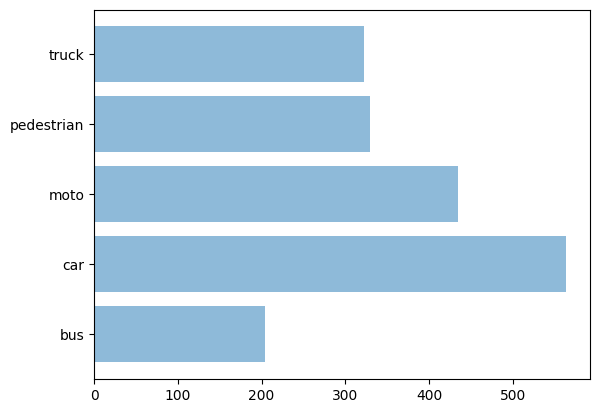

Total images: 1854


In [235]:
label, num_images = statistic()

y_pos = np.arange(len(label))

plt.barh(y_pos, num_images, align='center', alpha=0.5)
plt.yticks(y_pos, label)
plt.show()

print('Total images: %d' %(sum(num_images)))

### Câu hỏi 1.3: Xây dựng danh sách chứa ảnh

Xây dựng một list lưu trữ ảnh và nhãn tương ứng của nó. Hãy Viết hàm read_data(), hàm này trả về hai list X, Y, trong đó mỗi phần tử của list X lưu trữ một mảng numpy biểu diễn một ảnh và mỗi phần tử của list Y lưu trữ nhãn (dưới dạng số nguyên) tương ứng của ảnh.

In [236]:
def read_data(label2id):
    X = []
    Y = []
    for label in os.listdir('../TK1/trainingset'):
        label_path = os.path.join('../TK1/trainingset', label)
        if not os.path.isdir(label_path):  # Bỏ qua file không phải thư mục
            continue
        for img_file in os.listdir(os.path.join('../TK1/trainingset', label)):
            img = cv2.imread(os.path.join('../TK1/trainingset', label, img_file))            
            X.append(img)
            Y.append(label2id[label])
    return X, Y

In [237]:
# Label to id, used to convert string label to integer 
label2id = {'pedestrian':0, 'moto':1, 'truck':2, 'car':3, 'bus':4}
X, Y = read_data(label2id)
print(len(X))
print(len(Y))
print(X[0].shape)
print(Y[0])

1854
1854
(168, 134, 3)
4


## Câu hỏi 2: Trích xuất đặc trưng (features extraction)

Thực hiện trích xuất đặc trưng SIFT (SIFT keypoints descriptor), xây dựng từ điển và mô hình Bag-of-Word (BoW). Bạn hãy lập trình hoàn chỉnh các hàm theo yêu cầu cụ thể dưới đây

### Câu hỏi 2.1: Trích xuất đặc trưng SIFT

Hãy viết hàm extract_sift_features() nhận đầu vào là list ảnh ta đã xây dựng được từ câu hỏi trước và trả về list image_descriptors, phần tử thứ p trong list image_descriptors lại là một list chứa các SIFT keypoints descriptor ứng với ảnh thứ p trong list X.

Gợi ý: Để khởi tạo đối tượng SIFT trong OpenCV ta sử dụng lệnh: sift = cv2.xfeatures2d.SIFT_create(). Đối tượng này có phương thức detectAndCompute trả về 2 outputs kp và des, kp là một list chứa các keypoints được detect bởi SIFT, des là một numpy array chứa len(kp) vectors 128 chiều. Chúng ta sẽ dùng các des này để phục vụ bài toán phân loại.

In [238]:
def extract_sift_features(X):
    image_descriptors = []
    sift = cv2.AKAZE_create()

    for i in range(len(X)):        
        kp, des = sift.detectAndCompute(X[i], None)
        if des is not None:
            image_descriptors.append(des)
        else:
            image_descriptors.append([np.zeros(61)])

    return image_descriptors

In [239]:
#import pickle

image_descriptors = extract_sift_features(X)
#pickle.dump(image_descriptors, open('img_des.dump', 'wb'))
#image_descriptors = pickle.load(open('img_des.dump', 'rb'))
print(len(image_descriptors))
if len(image_descriptors) > 0 and len(image_descriptors[0]) > 1:
    print(np.array(image_descriptors[0][1]).shape)
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

1854
(61,)
Image 0 has 17 descriptors
Image 1 has 32 descriptors
Image 2 has 13 descriptors
Image 3 has 2 descriptors
Image 4 has 1 descriptors
Image 5 has 1 descriptors
Image 6 has 52 descriptors
Image 7 has 1 descriptors
Image 8 has 2 descriptors
Image 9 has 52 descriptors


### Câu hỏi 2.2: Xây dựng từ điển
Sử dụng hàm kmeans_bow() dưới đây nhận đầu vào là một list gồm tất cả các descriptors của các ảnh trong tập X và số cụm num_clusters, sử dụng thuật toán KMeans trong scikit-learn phân cụm các vector descriptors này thành num_clusters cụm. Hàm trả về một danh sách center của các cụm. Vì thao tác này mất rất nhiều thời gian nên ta sẽ lưu danh sách trả về bởi hàm kmeans_bow() ra một file nhị phân (sử dụng thư viện pickle) để tiện sử dụng sau này.

Trước tiên ta sẽ xây dựng một list chứa tất cả các descriptors:

In [240]:
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 37668


Đối tượng kmeans có phương thức fit, nhận vào các điểm dữ liệu (trong bài toán hiện tại của chúng ta là list all_descriptors) và tìm ra n_clusters vector là tâm của các cụm dữ liệu. Để lấy được các vector này ta sử dụng thuộc tính $cluster_centers_$  của đối tượng kmeans

In [241]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []

    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_

    return bow_dict

Lưu từ điển phục vụ cho việc sử dụng sau này:

In [242]:
num_clusters = 15

if not os.path.isfile('bow_dictionary.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)
    pickle.dump(BoW, open('bow_dictionary.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary.pkl', 'rb'))

# Đảm bảo BoW là mảng numpy 2D
BoW = np.array(BoW)
if BoW.ndim != 2:
    print(f"Error: BoW has incorrect shape {BoW.shape}, reshaping...")
    BoW = BoW.reshape(-1, 128)  # Điều chỉnh nếu số chiều đặc trưng khác

print(f"BoW shape: {BoW.shape}")
print(f"BoW type: {type(BoW[0])}")

BoW shape: (15, 61)
BoW type: <class 'numpy.ndarray'>


### Câu hỏi 2.3: Xây dựng vector đặc trưng với mô hình BoW

Sử dụng hàm create_features_bow() nhận đầu vào là list image_descriptors, list BoW và num_clusters ở trên, trả về list X_features, trong đó phần tử thứ p của X_vectors là vector đặc trưng theo mô hình BoW ứng với ảnh thứ p, tập keypoint descriptors thứ p. Hãy chú ý sự tương ứng các phần tử trong 4 danh sách: X, Y, image_descriptors, X_features.

In [243]:
from scipy.spatial.distance import cdist

In [244]:
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []
    descriptor_dim = BoW.shape[1]  # Lấy số chiều đặc trưng của BoW

    for i in range(len(image_descriptors)):
        features = np.zeros(num_clusters, dtype=int)

        if image_descriptors[i] is None or len(image_descriptors[i]) == 0:
            print(f"Warning: image_descriptors[{i}] is empty or None")
            X_features.append(features)  # Thêm vector 0 thay vì bỏ qua hoàn toàn
            continue

        image_descriptors[i] = np.array(image_descriptors[i])
        if image_descriptors[i].ndim == 1:
            image_descriptors[i] = image_descriptors[i].reshape(1, -1)
        elif image_descriptors[i].ndim != 2:
            print(f"Error: image_descriptors[{i}] has invalid shape {image_descriptors[i].shape}")
            X_features.append(features)  # Thêm vector 0 nếu lỗi
            continue

        # Kiểm tra số chiều đặc trưng có khớp với BoW không
        if image_descriptors[i].shape[1] != descriptor_dim:
            print(f"Error: image_descriptors[{i}] has shape {image_descriptors[i].shape}, but BoW expects {descriptor_dim} features.")
            X_features.append(features)  # Thêm vector 0 nếu lỗi
            continue

        # Tính khoảng cách và gán vào cụm gần nhất
        distance = cdist(image_descriptors[i], BoW)
        argmin = np.argmin(distance, axis=1)
        for j in argmin:
            features[j] += 1

        X_features.append(features)

    return np.array(X_features) if X_features else np.zeros((1, num_clusters))  # Đảm bảo không rỗng


In [245]:
X_features = create_features_bow(image_descriptors, BoW, num_clusters)
print(len(X_features))
print(X_features[0])
print(sum(X_features[0]))
print(image_descriptors[0].shape[0])

1854
[0 1 2 2 0 2 4 0 0 2 1 1 0 1 1]
17
17


## Câu hỏi 3: Xây dựng mô hình
Từ các câu hỏi trước chúng ta đã xây dựng được vector đặc trưng ứng với mỗi ảnh trong bộ dữ liệu. Ở câu hỏi này chúng ta sẽ xây dựng các mô hình phân loại SVM

In [246]:
print(len(X_features))
print(len(Y))

1854
1854


Chia tập dữ liệu thành tập train/test sử dụng train_test_split của sklearn:

In [247]:
from sklearn.model_selection import train_test_split

X_train = []
X_test = []
Y_train = []
Y_test = []

X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

1483
371


Khai báo đối tượng SVM:

In [248]:
svm = sklearn.svm.SVC(kernel='linear', C=1.0, random_state=42)
print(svm)

SVC(kernel='linear', random_state=42)


Huấn luyện, kiểm tra độ chính xác của mô hình tương tự như các bài học trước (sử dụng các hàm fit, predict, score,... của đối tượng svm)

Huấn luyện mô hình:

In [249]:
svm.fit(X_train, Y_train)

SVC(kernel='linear', random_state=42)

Tính độ chính xác trên tập dữ liệu huấn luyện:

In [250]:
train_accuracy = svm.score(X_train, Y_train)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.5306810519217802


Tính độ chính xác trên tập dữ liệu test:

In [251]:
# Tính độ chính xác
print("Test Accuracy:",svm.score(X_test, Y_test))

Test Accuracy: 0.48247978436657685


## Câu hỏi 4: Dùng mô hình đã huấn luyện dự đoán hình ảnh thực tế

Dùng mô hình đã huấn luyện để đưa ra dự đoán về một hình ảnh thực tế. Thực hiện lần lượt các bước: đọc ảnh, trích xuất đặc trưng BoW của ảnh, dự đoán sử dụng mô hình đã huấn luyện.

__Bước 1__: Đọc ảnh ở đường dẫn image_test/car.png, lưu ảnh vào biến img

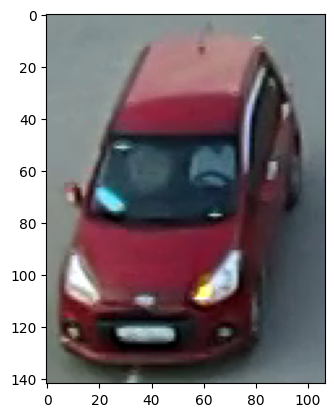

In [252]:
img = None

image_path = "../TK1/image_test/car.png"
img = cv2.imread(image_path)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

my_X = [img]

__Bước 2__: Trích xuất đặc trưng SIFT (lưu vào biến my_image_descriptors) và BoW (lưu vào biến my_X_features) từ my_X:

In [253]:
my_image_descriptors = None
my_X_features = None



my_image_descriptors = extract_sift_features(my_X)

if my_image_descriptors is None or len(my_image_descriptors) == 0:
    print("Error: No descriptors extracted from images!")

my_X_features = create_features_bow(my_X, BoW, num_clusters)
if len(my_X_features) == 0:
    print("Error: create_features_bow() returned an empty array!")

print(len(my_image_descriptors))
print(my_X_features[0].shape)

Error: image_descriptors[0] has invalid shape (142, 107, 3)
1
(15,)


__Bước 3:__ Sử dụng mô hình đã huấn luyện để dự đoán, kết quả dự đoán lưu vào biến my_y_pred

In [254]:
y_pred = None

########################
#### YOUR CODE HERE ####
########################

print(y_pred)
print(label2id)
# Get your label name using label2id variable (define above)
if y_pred is None or len(y_pred) == 0:
    print("Error: y_pred is None or empty!")
else:
    for key, value in label2id.items():
        if value == y_pred[0]:
            print('Your prediction:', key)

None
{'pedestrian': 0, 'moto': 1, 'truck': 2, 'car': 3, 'bus': 4}
Error: y_pred is None or empty!


# Câu hỏi 5

1. Thử nghiệm thuật toán trích xuất đặc trưng BoW với số lượng từ trong từ điển khác nhau 10, 20, 50, 100, 200. Vẽ biểu đồ độ chính xác trên tập test ứng với từng trường hợp.

2. Sử dụng GridSearchCV của sklearn để tìm tham số tốt nhất cho mô hình SVM.

3. Thay SVM bằng các bộ phân loại: K-Nearest Neighbors, Random forest. So sánh các kết quả và đưa ra nhận xét.

1. Thử nghiệm thuật toán trích xuất đặc trưng BoW với số lượng từ trong từ điển khác nhau 10, 20, 50, 100, 200. Vẽ biểu đồ độ chính xác trên tập test ứng với từng trường hợp.

🔹 Testing with 10 clusters...
✅ Accuracy with 10 clusters: 0.6226
🔹 Testing with 20 clusters...
✅ Accuracy with 20 clusters: 0.6146
🔹 Testing with 50 clusters...
✅ Accuracy with 50 clusters: 0.6739
🔹 Testing with 100 clusters...
✅ Accuracy with 100 clusters: 0.6981
🔹 Testing with 200 clusters...
✅ Accuracy with 200 clusters: 0.7197


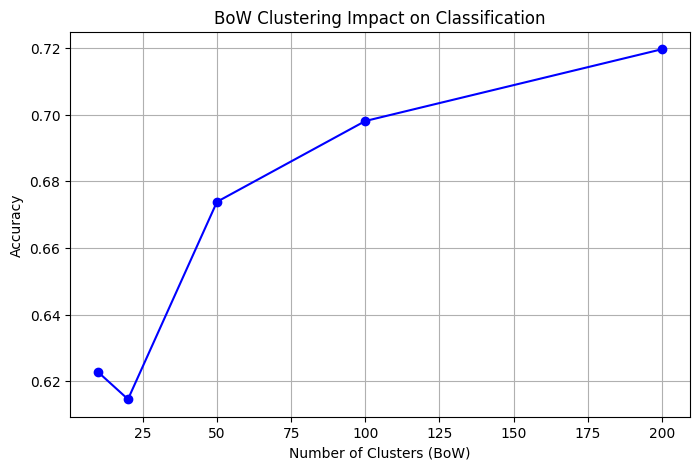

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

def load_images(image_folder):
    images, labels = [], []
    label_map = {}  # Ánh xạ tên thư mục thành nhãn số

    for label_id, class_name in enumerate(os.listdir(image_folder)):
        class_path = os.path.join(image_folder, class_name)
        if not os.path.isdir(class_path):  # Bỏ qua nếu không phải thư mục
            continue

        label_map[class_name] = label_id  # Lưu ánh xạ nhãn
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label_id)

    return np.array(images), np.array(labels), label_map

def evaluate_bow(num_clusters_list, X_train, y_train, X_test, y_test):
    accuracies = []

    for num_clusters in num_clusters_list:
        print(f"🔹 Testing with {num_clusters} clusters...")

        # Tạo từ điển BoW
        BoW = kmeans_bow(train_descriptors, num_clusters)

        # Trích xuất đặc trưng BoW
        X_train_features = create_features_bow(X_train, BoW, num_clusters)
        X_test_features = create_features_bow(X_test, BoW, num_clusters)

        # Train SVM
        model = SVC(kernel='linear', C=1.0, random_state=42)
        model.fit(X_train_features, y_train)

        # Dự đoán và tính độ chính xác
        y_pred = model.predict(X_test_features)
        acc = accuracy_score(y_test, y_pred)

        print(f"✅ Accuracy with {num_clusters} clusters: {acc:.4f}")
        accuracies.append(acc)

    return accuracies

X, y, label_map = load_images("trainingset")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_descriptors = extract_sift_features(X_train)

num_clusters_list = [10, 20, 50, 100, 200]
accuracies = evaluate_bow(num_clusters_list, X_train, y_train, X_test, y_test)

plt.figure(figsize=(8, 5))
plt.plot(num_clusters_list, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (BoW)")
plt.ylabel("Accuracy")
plt.title("BoW Clustering Impact on Classification")
plt.grid(True)
plt.show()


Nhận xét biểu đồ sự tác động của số cụm trong phân lớp :
- Độ chính xác khi số lượng cụm tăng dần từ 25% lên 72%

2. Sử dụng GridSearchCV của sklearn để tìm tham số tốt nhất cho mô hình SVM.

In [259]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# 🟢 1. Xác định lưới tham số cần thử nghiệm
param_grid = {
    'C': [0.1, 1, 10, 100],         # Regularization strength
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]  # Gamma chỉ áp dụng cho RBF/POLY
}

# 🟢 2. Khởi tạo mô hình SVM
svm_model = SVC(random_state=42)
 # Tạo từ điển BoW
BoW = kmeans_bow(train_descriptors, num_clusters)


# Trích xuất đặc trưng BoW
X_train_features = create_features_bow(X_train, BoW, num_clusters)
X_test_features = create_features_bow(X_test, BoW, num_clusters)

# 🟢 3. Chạy GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_features, y_train)  # Huấn luyện trên dữ liệu đặc trưng BoW

# 🟢 4. In ra kết quả tốt nhất
print("Best parameters:", grid_search.best_params_)
print("Best training accuracy:", grid_search.best_score_)

# 🟢 5. Đánh giá trên tập test với mô hình tốt nhất
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_features, y_test)
print("Test Accuracy with Best Parameters:", test_accuracy)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best training accuracy: 0.6905155155155154
Test Accuracy with Best Parameters: 0.6765498652291105


3. Thay SVM bằng các bộ phân loại: K-Nearest Neighbors, Random forest. So sánh các kết quả và đưa ra nhận xét.

In [ ]:
num_clusters = 15

if not os.path.isfile('bow_dictionary.pkl'):
    BoW = kmeans_bow(all_descriptors, num_clusters)
    pickle.dump(BoW, open('bow_dictionary.pkl', 'wb'))
else:
    BoW = pickle.load(open('bow_dictionary.pkl', 'rb'))

# Đảm bảo BoW là mảng numpy 2D
BoW = np.array(BoW)
if BoW.ndim != 2:
    print(f"Error: BoW has incorrect shape {BoW.shape}, reshaping...")
    BoW = BoW.reshape(-1, 128)  # Điều chỉnh nếu số chiều đặc trưng khác

print(f"BoW shape: {BoW.shape}")
print(f"BoW type: {type(BoW[0])}")

BoW shape: (15, 61)
BoW type: <class 'numpy.ndarray'>


K-Nearest Neighbors

🔍 Extracting SIFT Features: 100%|██████████| 371/371 [00:00<00:00, 428.57it/s]


🔹 Testing with 10 clusters...
🔹 Training BoW with 10 clusters...
✅ KNN accuracy with 10 clusters: 0.6092
🔹 Testing with 20 clusters...
🔹 Training BoW with 20 clusters...
✅ KNN accuracy with 20 clusters: 0.6550
🔹 Testing with 50 clusters...
🔹 Training BoW with 50 clusters...
✅ KNN accuracy with 50 clusters: 0.6307
🔹 Testing with 100 clusters...
🔹 Training BoW with 100 clusters...
✅ KNN accuracy with 100 clusters: 0.6226
🔹 Testing with 200 clusters...
🔹 Training BoW with 200 clusters...
✅ KNN accuracy with 200 clusters: 0.5445


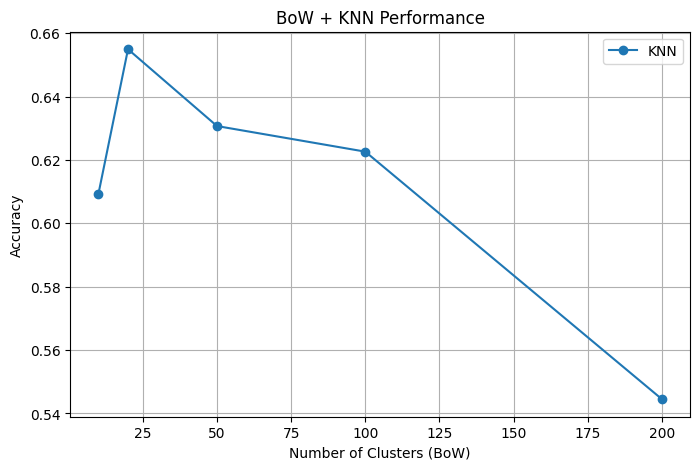

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def train_and_evaluate_knn(X_train, y_train, X_test, y_test):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

def evaluate_bow_knn(num_clusters_list, X_train, y_train, X_test, y_test):
    knn_accuracies = []

    for num_clusters in num_clusters_list:
        print(f"🔹 Testing with {num_clusters} clusters...")

        BoW = kmeans_bow(all_descriptors_train, num_clusters)
        X_train_features = create_features_bow(image_descriptors_train, BoW, num_clusters)
        X_test_features = create_features_bow(image_descriptors_test, BoW, num_clusters)

        acc = train_and_evaluate_knn(X_train_features, y_train, X_test_features, y_test)
        knn_accuracies.append(acc)
        print(f"✅ KNN accuracy with {num_clusters} clusters: {acc:.4f}")

    return knn_accuracies


# 1. Load dữ liệu
X, y, label_map = load_images("trainingset")

# 2. Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Trích xuất đặc trưng SIFT
image_descriptors_train, all_descriptors_train = extract_sift_features(X_train)
image_descriptors_test, all_descriptors_test = extract_sift_features(X_test)

# 4. Đánh giá với các số lượng từ điển khác nhau
num_clusters_list = [10, 20, 50, 100, 200]
knn_accuracies = evaluate_bow_knn(num_clusters_list, X_train, y_train, X_test, y_test)

# 5. Vẽ biểu đồ kết quả KNN
plt.figure(figsize=(8, 5))
plt.plot(num_clusters_list, knn_accuracies, marker='o', linestyle='-', label="KNN")

plt.xlabel("Number of Clusters (BoW)")
plt.ylabel("Accuracy")
plt.title("BoW + KNN Performance")
plt.legend()
plt.grid(True)
plt.show()


Hiệu suất KNN không tăng theo số cụm:

- Độ chính xác cao nhất ở khoảng 20 cụm (~66%).
- Khi số cụm tăng lên 50, 100, 200, độ chính xác giảm dần.

Random forest

🔍 Extracting SIFT Features: 100%|██████████| 371/371 [00:00<00:00, 425.97it/s]


🔹 Testing with 10 clusters using Random Forest...
🔹 Training BoW with 10 clusters...
✅ Accuracy with 10 clusters: 0.6685
🔹 Testing with 20 clusters using Random Forest...
🔹 Training BoW with 20 clusters...
✅ Accuracy with 20 clusters: 0.7035
🔹 Testing with 50 clusters using Random Forest...
🔹 Training BoW with 50 clusters...
✅ Accuracy with 50 clusters: 0.7466
🔹 Testing with 100 clusters using Random Forest...
🔹 Training BoW with 100 clusters...
✅ Accuracy with 100 clusters: 0.7736
🔹 Testing with 200 clusters using Random Forest...
🔹 Training BoW with 200 clusters...
✅ Accuracy with 200 clusters: 0.7224


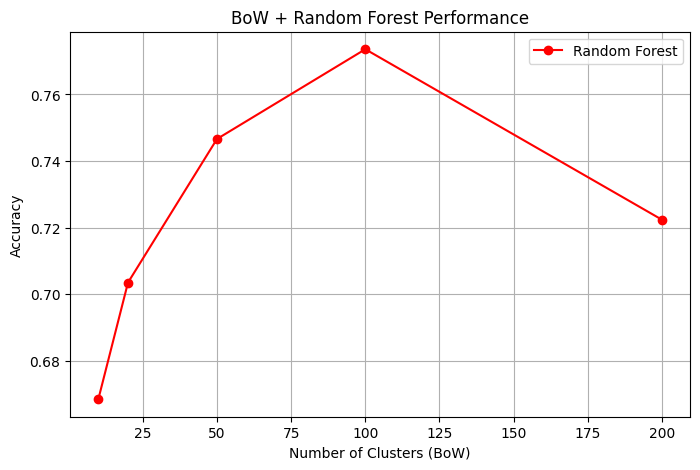

In [ ]:
from sklearn.ensemble import RandomForestClassifier


def evaluate_bow_with_rf(num_clusters_list, all_descriptors, X_train_desc, y_train, X_test_desc, y_test):
    accuracies = []
    
    for num_clusters in num_clusters_list:
        print(f"🔹 Testing with {num_clusters} clusters using Random Forest...")

        # Tạo BoW dictionary
        BoW = kmeans_bow(all_descriptors, num_clusters)
        if BoW is None:
            accuracies.append(0)  # Nếu không đủ đặc trưng, thêm 0 vào danh sách accuracy
            continue  

        # Trích xuất đặc trưng BoW
        X_train_features = create_features_bow(X_train_desc, BoW, num_clusters)
        X_test_features = create_features_bow(X_test_desc, BoW, num_clusters)

        # Train Random Forest
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train_features, y_train)

        # Dự đoán
        y_pred = model.predict(X_test_features)

        # Tính accuracy
        acc = accuracy_score(y_test, y_pred)
        print(f"✅ Accuracy with {num_clusters} clusters: {acc:.4f}")
        accuracies.append(acc)

    return accuracies



image_folder = "trainingset"  # Cập nhật đường dẫn dataset
images, labels, label_map = load_images(image_folder)

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Trích xuất đặc trưng SIFT
X_train_desc, all_descriptors_train = extract_sift_features(X_train)
X_test_desc, _ = extract_sift_features(X_test)  # Không cần gom cụm test

# Danh sách số cụm thử nghiệm
num_clusters_list = [10, 20, 50, 100, 200]

# Chạy thử nghiệm với Random Forest
accuracies_rf = evaluate_bow_with_rf(num_clusters_list, all_descriptors_train, X_train_desc, y_train, X_test_desc, y_test)

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(num_clusters_list, accuracies_rf, marker='o', linestyle='-', label="Random Forest", color='r')
plt.xlabel("Number of Clusters (BoW)")
plt.ylabel("Accuracy")
plt.title("BoW + Random Forest Performance")
plt.legend()
plt.grid(True)
plt.show()


Nhận xét: 
- Xu hướng hợp lý: Accuracy tăng dần khi số cụm tăng từ 10 đến 100, điều này cho thấy việc sử dụng nhiều cụm hơn giúp mô hình phân biệt đặc trưng tốt hơn.
- Điểm tối ưu: Với 100 clusters, accuracy đạt cao nhất (~0.77), cho thấy đây có thể là số cụm tối ưu.

#### End